# Importing Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import zipfile
import shutil
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications import VGG16, InceptionV3, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')  
import gradio as gr


# Loading Dataset

In [9]:
import os
import zipfile
import shutil

# Paths for the dataset zip and extraction folder
dataset_zip = "PlantVillage.zip"
dataset_path = "PlantVillage"

# Unzipping the dataset
if not os.path.exists(dataset_path):
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall()

    # Check if an extra "PlantVillage/PlantVillage" folder was created
    nested_folder = os.path.join(dataset_path, "PlantVillage")

    if os.path.exists(nested_folder):  
        # Move files from nested folder to the correct location
        for item in os.listdir(nested_folder):
            shutil.move(os.path.join(nested_folder, item), dataset_path)

        # Remove the empty nested folder
        os.rmdir(nested_folder)

In [10]:
# List all classes in the dataset
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

print("Plant Village Classes:")
for plant_class in classes:
    print(f" - {plant_class}")


Plant Village Classes:
 - Pepper__bell___Bacterial_spot
 - Pepper__bell___healthy
 - Potato___Early_blight
 - Potato___healthy
 - Potato___Late_blight
 - Tomato_Bacterial_spot
 - Tomato_Early_blight
 - Tomato_healthy
 - Tomato_Late_blight
 - Tomato_Leaf_Mold
 - Tomato_Septoria_leaf_spot
 - Tomato_Spider_mites_Two_spotted_spider_mite
 - Tomato__Target_Spot
 - Tomato__Tomato_mosaic_virus
 - Tomato__Tomato_YellowLeaf__Curl_Virus


# Data Preparation

In [11]:
file_paths = []
labels = []

for plant_class in classes:
    class_path = os.path.join(dataset_path, plant_class)
    for file in os.listdir(class_path):
        if file.endswith(('.jpg', '.jpeg', '.png', '.JPG')):
            file_paths.append(os.path.join(class_path, file))
            labels.append(plant_class)

# Convert labels to numerical format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# One-hot encoding
labels_one_hot = to_categorical(labels_encoded, num_classes=len(classes))

# Train-test split (80% training, 20% validation)
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths, labels_one_hot, test_size=0.2, stratify=labels_encoded, random_state=42
)

print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

Training samples: 16510, Validation samples: 4128


# Data Augmentation

In [12]:
# Enable Mixed Precision Training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define Dataset Path
dataset_path = "PlantVillage"

# Get Class Names
classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
num_classes = len(classes)

print(f"Found {num_classes} Classes: {classes}")

# Image Augmentation
datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=30, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    validation_split=0.2
)

# Data Generators
train_generator = datagen.flow_from_directory(
    dataset_path, target_size=(128, 128), batch_size=64, class_mode='categorical', subset='training')

val_generator = datagen.flow_from_directory(
    dataset_path, target_size=(128, 128), batch_size=64, class_mode='categorical', subset='validation')



Found 15 Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


# Model Building

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf

# Function to Evaluate Each Model
def evaluate_model(model, val_generator, model_name):
    print(f"\n Evaluating {model_name}...")

    # Get True Labels & Predictions
    val_preds = model.predict(val_generator)
    val_preds_classes = np.argmax(val_preds, axis=1)
    val_true_classes = val_generator.classes

    # Compute Accuracy
    accuracy = np.mean(val_preds_classes == val_true_classes)
    print(f"\ {model_name} Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(val_true_classes, val_preds_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # Compute AUC Score
    auc_score = roc_auc_score(tf.keras.utils.to_categorical(val_true_classes, num_classes), val_preds, multi_class='ovr')
    print(f"\n🔹 {model_name} AUC Score: {auc_score:.4f}")

    # ROC Curve for Each Class
    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(val_true_classes, num_classes)[:, i], val_preds[:, i])
        plt.plot(fpr, tpr, label=f"Class {i}: {classes[i]}")
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - AUC Curve")
    plt.legend()
    plt.show()

    # Classification Report
    print(f"\n {model_name} Classification Report:")
    print(classification_report(val_true_classes, val_preds_classes, target_names=classes))


In [14]:
steps_per_epoch = 100  
validation_steps = 50 

## VGG16 Model

In [15]:
# VGG16 Model
def create_vgg16_model(input_shape=(128, 128, 3), num_classes=num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freezing the layers of VGG16
    for layer in base_model.layers:
        layer.trainable = False

    # Adding custom layers
    model = Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax', dtype='float32'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create VGG16 Model
vgg16_model = create_vgg16_model()

# Train the model
vgg16_model.fit(train_generator, validation_data=val_generator, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,  epochs= 5, callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=3)])


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 783s 8s/step - accuracy: 0.2202 - loss: 2.4951 - val_accuracy: 0.5456 - val_loss: 1.6330 - learning_rate: 1.0000e-04
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 862s 9s/step - accuracy: 0.4793 - loss: 1.7148 - val_accuracy: 0.6225 - val_loss: 1.3039 - learning_rate: 1.0000e-04
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 614s 6s/step - accuracy: 0.5658 - loss: 1.4215 - val_accuracy: 0.6516 - val_loss: 1.2094 - learning_rate: 1.0000e-04
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 840s 8s/step - accuracy: 0.5655 - loss: 1.3477 - val_accuracy: 0.6766 - val_loss: 1.0859 - learning_rate: 1.0000e-04
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 843s 8s/step - accuracy: 0.5990 - loss: 1.2597 - val_accuracy: 0.6809 - val_loss: 1.0431 - learning_rate: 1.0000e-04


In [16]:
vgg16_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,018,483 (80.18 MB)

 Trainable params: 2,101,263 (8.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 4,202,532 (16.03 MB)


 Evaluating VGG16...
65/65 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step
\ VGG16 Accuracy: 0.0835


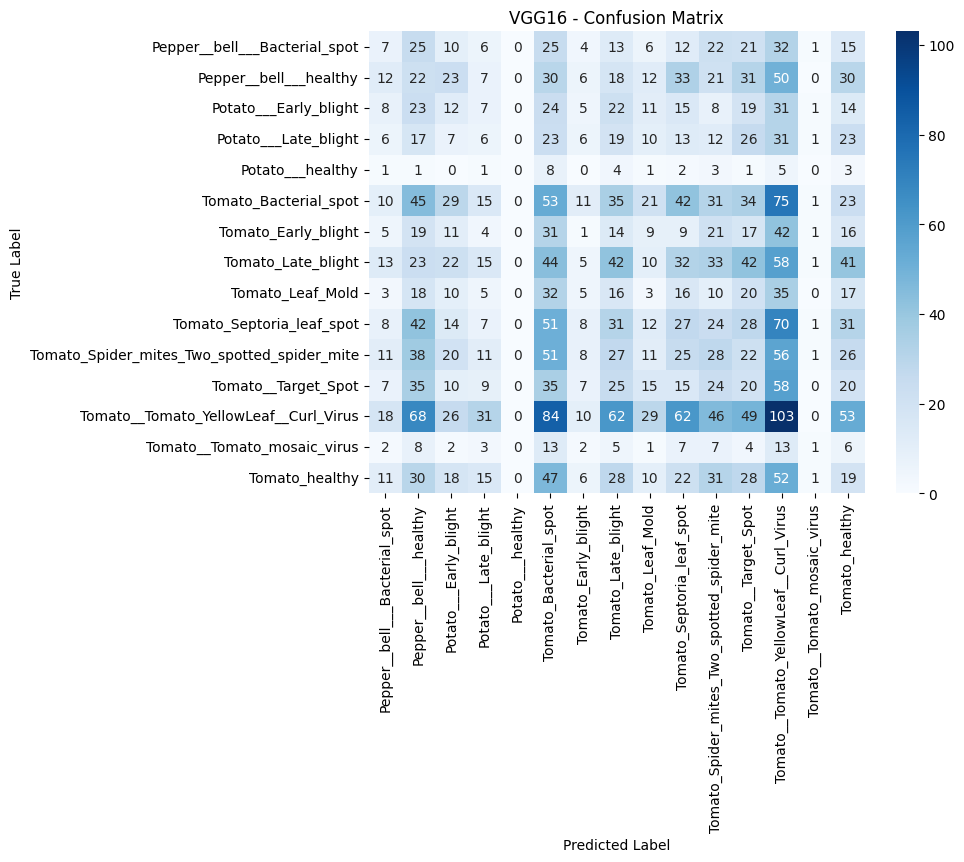


🔹 VGG16 AUC Score: 0.4935


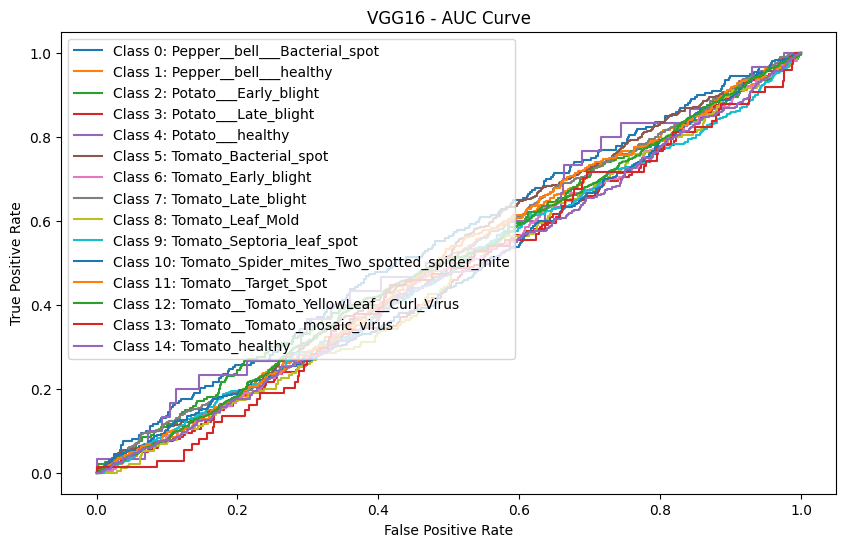


 VGG16 Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.06      0.04      0.04       199
                     Pepper__bell___healthy       0.05      0.07      0.06       295
                      Potato___Early_blight       0.06      0.06      0.06       200
                       Potato___Late_blight       0.04      0.03      0.04       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.10      0.12      0.11       425
                        Tomato_Early_blight       0.01      0.01      0.01       200
                         Tomato_Late_blight       0.12      0.11      0.11       381
                           Tomato_Leaf_Mold       0.02      0.02      0.02       190
                  Tomato_Septoria_leaf_spot       0.08      0.08      0.08       354
Tomato_Spider_mites_Two_spotted_s

In [17]:
evaluate_model(vgg16_model, val_generator, "VGG16")


## ResNet Model

In [18]:
# ResNet50 Model
def create_resnet50_model(input_shape=(128, 128, 3), num_classes=num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freezing the layers of ResNet50
    for layer in base_model.layers:
        layer.trainable = False

    # Adding custom layers
    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax', dtype='float32'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create ResNet50 Model
resnet50_model = create_resnet50_model()

# Train the model
resnet50_model.fit(train_generator, validation_data=val_generator, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=5, callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=3)])


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 463s 4s/step - accuracy: 0.0726 - loss: 2.9264 - val_accuracy: 0.1584 - val_loss: 2.5797 - learning_rate: 1.0000e-04
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - accuracy: 0.1166 - loss: 2.6742 - val_accuracy: 0.1559 - val_loss: 2.5603 - learning_rate: 1.0000e-04
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.1191 - loss: 2.6297 - val_accuracy: 0.1553 - val_loss: 2.5558 - learning_rate: 1.0000e-04
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - accuracy: 0.1329 - loss: 2.6088 - val_accuracy: 0.1559 - val_loss: 2.5476 - learning_rate: 1.0000e-04
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.1477 - loss: 2.5713 - val_accuracy: 0.1575 - val_loss: 2.5409 - learning_rate: 1.0000e-04


In [19]:
resnet50_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,172,915 (96.03 MB)

 Trainable params: 528,399 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,056,804 (4.03 MB)


 Evaluating ResNet50...
65/65 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step
\ ResNet50 Accuracy: 0.1555


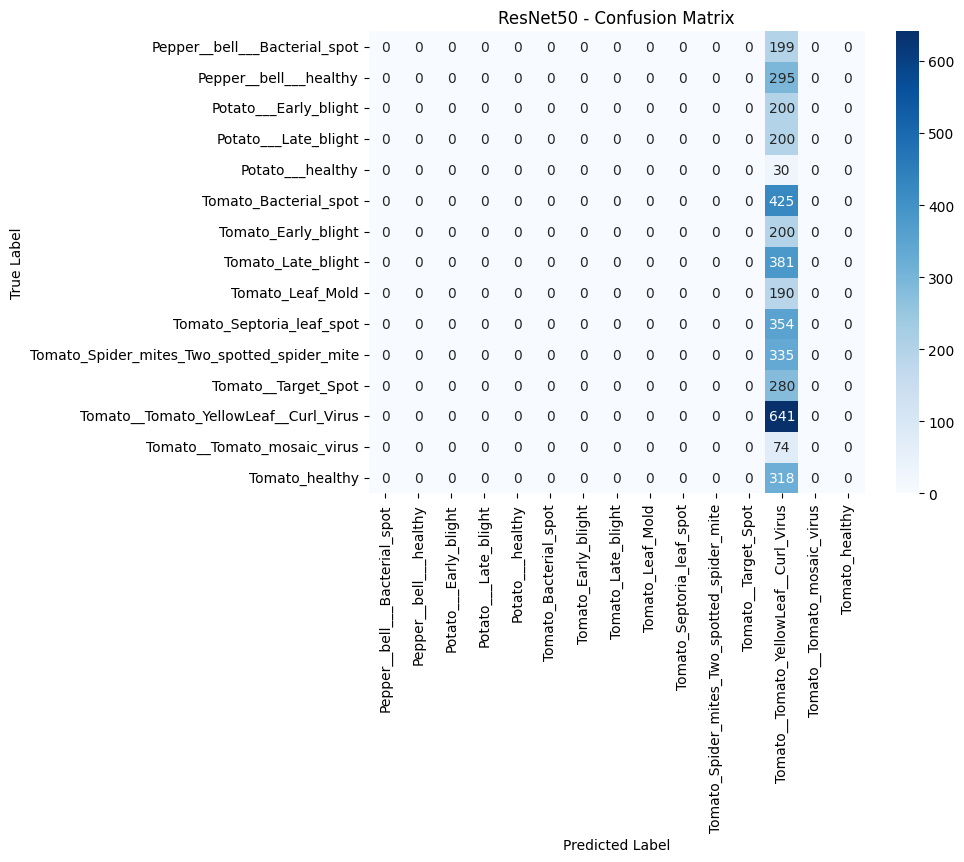


🔹 ResNet50 AUC Score: 0.5011


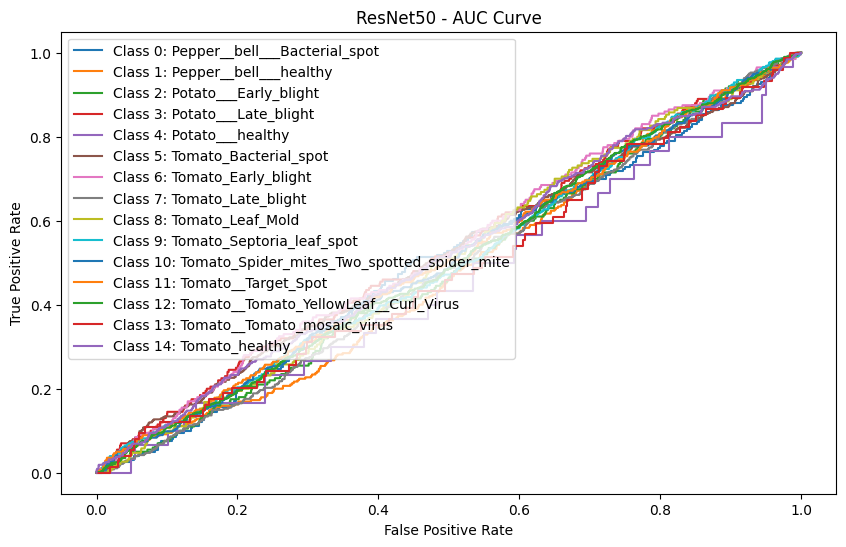


 ResNet50 Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.00      0.00       199
                     Pepper__bell___healthy       0.00      0.00      0.00       295
                      Potato___Early_blight       0.00      0.00      0.00       200
                       Potato___Late_blight       0.00      0.00      0.00       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.00      0.00      0.00       425
                        Tomato_Early_blight       0.00      0.00      0.00       200
                         Tomato_Late_blight       0.00      0.00      0.00       381
                           Tomato_Leaf_Mold       0.00      0.00      0.00       190
                  Tomato_Septoria_leaf_spot       0.00      0.00      0.00       354
Tomato_Spider_mites_Two_spotte

In [20]:
evaluate_model(resnet50_model, val_generator, "ResNet50")


## Inception Model

In [21]:
# InceptionV3 Model
def create_inceptionv3_model(input_shape=(128, 128, 3), num_classes=num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freezing the layers of InceptionV3
    for layer in base_model.layers:
        layer.trainable = False

    # Adding custom layers
    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax', dtype='float32'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create InceptionV3 Model
inceptionv3_model = create_inceptionv3_model()

# Train the model
inceptionv3_model.fit(train_generator, validation_data=val_generator, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,  epochs= 5, callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=3)])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.1501 - loss: 3.6486 - val_accuracy: 0.3756 - val_loss: 2.0803 - learning_rate: 1.0000e-04
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.3039 - loss: 2.2174 - val_accuracy: 0.4675 - val_loss: 1.7680 - learning_rate: 1.0000e-04
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.3800 - loss: 1.9529 - val_accuracy: 0.5216 - val_loss: 1.6118 - learning_rate: 1.0000e-04
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.4231 - loss: 1.8756 - val_accuracy: 0.5603 - val_loss: 1.4378 - learning_rate: 1.0000e-04
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.4680 - loss: 1.7064 - val_accuracy: 0.5816 - val_loss: 1.3514 - learning_rate: 1.0000e-04


In [22]:
inceptionv3_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,387,987 (89.22 MB)

 Trainable params: 528,399 (2.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 1,056,804 (4.03 MB)


 Evaluating InceptionV3...
65/65 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step
\ InceptionV3 Accuracy: 0.0927


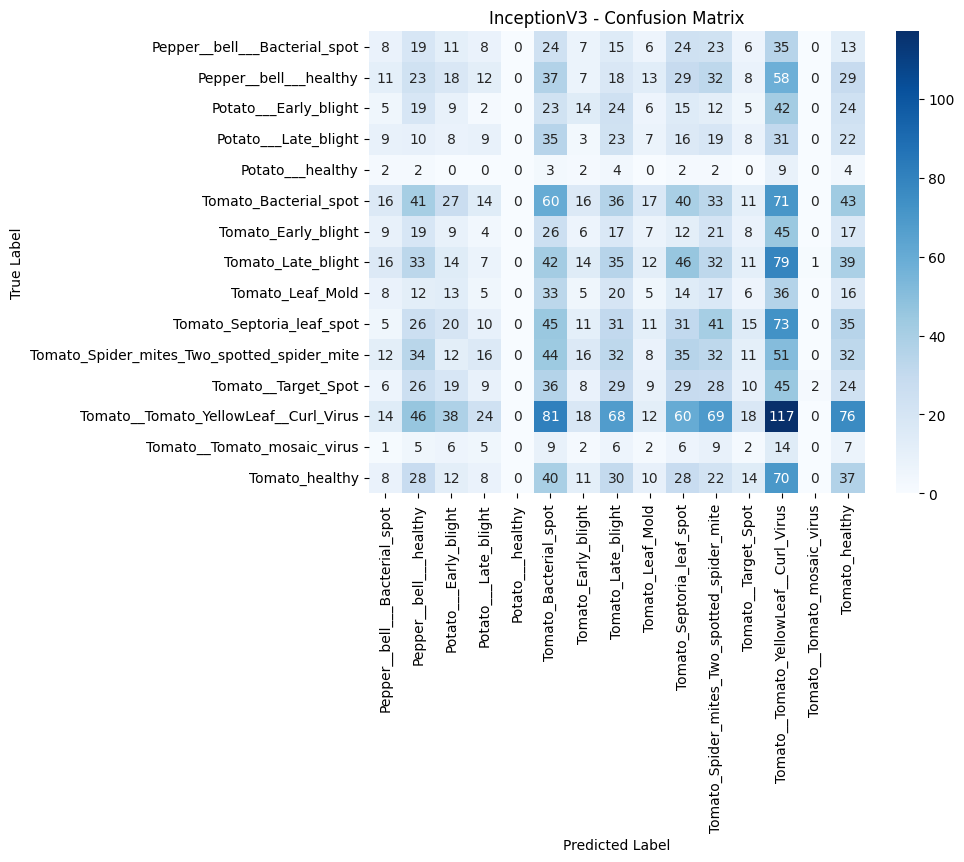


🔹 InceptionV3 AUC Score: 0.5012


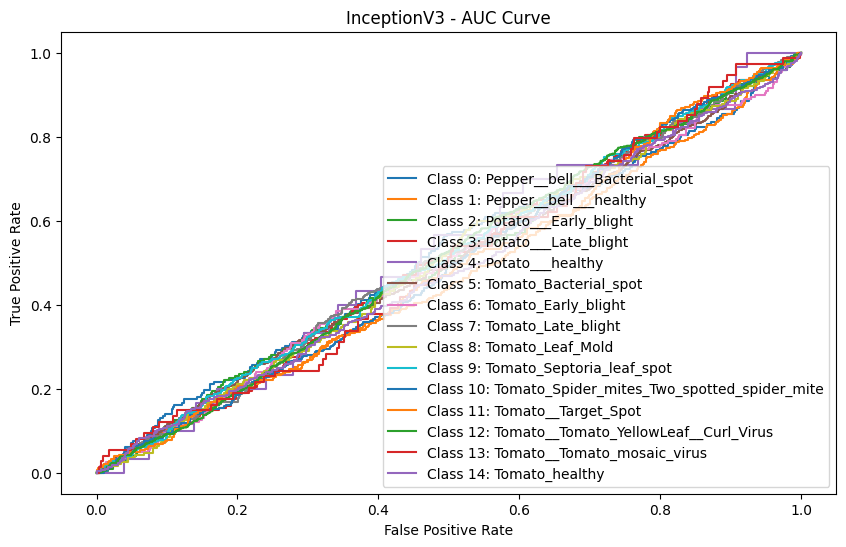


 InceptionV3 Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.06      0.04      0.05       199
                     Pepper__bell___healthy       0.07      0.08      0.07       295
                      Potato___Early_blight       0.04      0.04      0.04       200
                       Potato___Late_blight       0.07      0.04      0.05       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.11      0.14      0.12       425
                        Tomato_Early_blight       0.04      0.03      0.04       200
                         Tomato_Late_blight       0.09      0.09      0.09       381
                           Tomato_Leaf_Mold       0.04      0.03      0.03       190
                  Tomato_Septoria_leaf_spot       0.08      0.09      0.08       354
Tomato_Spider_mites_Two_spo

In [23]:
evaluate_model(inceptionv3_model, val_generator, "InceptionV3")

# Comparison of the Models

In [25]:
# Create a dictionary to store results
model_results = {
    "Model": ["VGG16", "ResNet50", "InceptionV3"],
    "Validation Accuracy": [
        vgg16_model.evaluate(val_generator, verbose=0)[1],
        resnet50_model.evaluate(val_generator, verbose=0)[1],
        inceptionv3_model.evaluate(val_generator, verbose=0)[1],
    ],
}

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(model_results)
print(results_df)


         Model  Validation Accuracy
0        VGG16             0.803493
1     ResNet50             0.155507
2  InceptionV3             0.587094


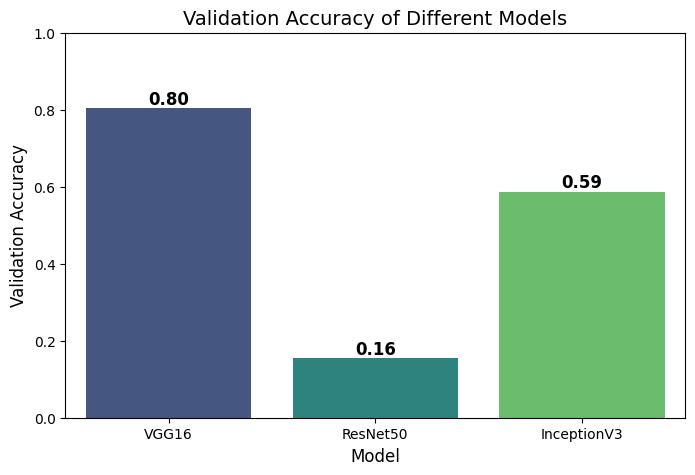

In [31]:
# Plot the validation accuracy
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Validation Accuracy", data=results_df, palette="viridis")

# Add title and labels
plt.title("Validation Accuracy of Different Models", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)

# Show accuracy values on bars
for index, value in enumerate(results_df["Validation Accuracy"]):
    plt.text(index, value + 0.01, f"{value:.2f}", ha="center", fontsize=12, fontweight="bold")

# Display the plot
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
plt.show()


# Save the models

In [30]:
# Save models
vgg16_model.save("vgg16_plant_disease.keras")
resnet50_model.save("resnet50_plant_disease.keras")
inceptionv3_model.save("inceptionv3_plant_disease.keras")

print("Models Saved Successfully!")


Models Saved Successfully!


Best Model

In [32]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("vgg16_plant_disease.keras")

# Load class names
classes = [
    "Pepper__bell___Bacterial_spot",
    "Pepper__bell___healthy",
    "Potato___Early_blight",
    "Potato___healthy",
    "Potato___Late_blight",
    "Tomato_Bacterial_spot",
    "Tomato_Early_blight",
    "Tomato_healthy",
    "Tomato_Late_blight",
    "Tomato_Leaf_Mold",
    "Tomato_Septoria_leaf_spot",
    "Tomato_Spider_mites_Two_spotted_spider_mite",
    "Tomato__Target_Spot",
    "Tomato__Tomato_mosaic_virus",
    "Tomato__Tomato_YellowLeaf__Curl_Virus",
]


In [33]:
# Dictionary of precautionary measures
precautions = {
    "Bacterial Spot": "Remove infected plants, avoid overhead watering, use copper-based fungicides.",
    "Early Blight": "Use disease-resistant varieties, rotate crops, remove affected leaves.",
    "Late Blight": "Apply fungicides, avoid wet conditions, destroy infected plants.",
    "Leaf Mold": "Ensure good air circulation, reduce humidity, use fungicides.",
    "Septoria Leaf Spot": "Use fungicides, remove infected leaves, avoid overhead watering.",
    "Spider Mites": "Spray with neem oil, maintain humidity, introduce beneficial insects.",
    "Target Spot": "Use fungicides, rotate crops, keep the garden clean.",
    "Tomato Mosaic Virus": "Remove infected plants, disinfect tools, control aphids.",
    "Tomato Yellow Leaf Curl Virus": "Control whiteflies, remove infected plants, use virus-resistant varieties.",
}


# Gradio UI

In [38]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
best_model = load_model("vgg16_plant_disease.keras")

# Define class names and precautions
classes = ["Healthy", "Disease1", "Disease2"]  # Replace with actual class names
precautions = {
    "Disease1": "Use organic pesticides.",
    "Disease2": "Water the plant properly."
}

# Function to Predict Disease & Suggest Solution
def predict_plant_disease(img):
    img = img.resize((150, 150))  # Ensure correct size
    img_array = np.array(img, dtype=np.float32)  # Convert to float32
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimension for batch
    img_array /= 255.0  # Normalize pixel values

    # Predict using the model
    predictions = best_model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = classes[predicted_class_index]

    # Get Precautionary Advice
    disease_name = predicted_class.split("___")[-1]  # Extract disease type
    precaution = precautions.get(disease_name, "No specific precautions available.")

    return f"Predicted Class: {predicted_class}", f"Precaution: {precaution}"

# Build Gradio UI
gr.Interface(
    fn=predict_plant_disease,
    inputs=gr.Image(type="pil"),
    outputs=["text", "text"],
    title="Plant Disease Detection",
    description="Upload a leaf image, and the model will predict the disease & suggest precautions.",
).launch()


* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\cindu\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cindu\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cindu\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 2096, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cindu\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 1643, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cindu\AppData\Local\P

Created dataset file at: .gradio\flagged\dataset1.csv
